In [10]:
#Import packages
import pandas as pd
import numpy as np
import scipy
from scipy import stats
from scipy.stats import norm
from matplotlib import pyplot as plt
from scipy.optimize import minimize
from decimal import Decimal


In [11]:
# Read CSV files
data = pd.read_csv('DataLab4.csv')
# data is of different frequency so I keep it in seperate dataframes
print(data)

  Rating  Prob_Loan_BBB  Loss_BBB  Prob_Loan_A  Loss_A
0    AAA         0.0002     -2.28       0.0009   -0.45
1     AA         0.0033     -2.10       0.0227   -0.23
2      A         0.0595     -1.57       0.9105   -0.12
3    BBB         0.8693     -0.46       0.0552    1.08
4     BB         0.0530      5.07       0.0074    3.16
5      B         0.0117      8.99       0.0026    5.56
6    CCC         0.0012     23.45       0.0001   18.78
7      D         0.0018     55.96       0.0006   55.96


In [12]:
#1
exp_trans = pd.DataFrame()
exp_trans['Rating'] = data.Rating
exp_trans['Expected nr of transitions BBB'] = round(data.Prob_Loan_BBB*100000, 0)
exp_trans['Expected nr of transitions A'] = round(data.Prob_Loan_A*100000, 0)

print("Number of expected ratings for one year with 100 000 draws:")    
print(exp_trans)


Number of expected ratings for one year with 100 000 draws:
  Rating  Expected nr of transitions BBB  Expected nr of transitions A
0    AAA                            20.0                          90.0
1     AA                           330.0                        2270.0
2      A                          5950.0                       91050.0
3    BBB                         86930.0                        5520.0
4     BB                          5300.0                         740.0
5      B                          1170.0                         260.0
6    CCC                           120.0                          10.0
7      D                           180.0                          60.0


In [20]:
#2 
losses = []
n = 8

#Assuming zero asset correlation
for i in range(n):
    for j in range(n):
        losses += [(data.Loss_BBB[i] + data.Loss_A[j], data.Prob_Loan_BBB[i]*data.Prob_Loan_A[j])]
      

sorted_losses = sorted(losses, key=lambda x: x[0])


EX_2 = 0
mu = 0 
for i in range(n*n):
    EX_2 += (sorted_losses[i][0]**2)*sorted_losses[i][1]
    mu += sorted_losses[i][0]*sorted_losses[i][1]

std_p = np.sqrt(EX_2 - mu**2)
print("Volatility of portfolio = " + str(std_p)) #hmm not exactly the same as in instructions... strange


alpha = [0.99, 0.999, 0.9999]
VaR = [0, 0, 0]
#VaR def: min{l: P(L > l) <= 1 - alpha}

for i in range(len(alpha)): #looks a bit odd but just do this for the example in L3 slide 19
    idx = len(sorted_losses) - 1 #start at the end of sorted losses
    prob = 0 #start prob
    while prob <= 1 - alpha[i]: #definition of discrete VaR
        VaR[i] = sorted_losses[idx][0]
        prob += sorted_losses[idx][1] #add up probs
        idx -= 1 #go one step left

    VaR[i] = sorted_losses[idx-1][0] #discrete distribution, one step further to left gives min l

    print("VaR with alpha = " + str(alpha[i]) + " is " + str(VaR[i]))



Volatility of portfolio = 3.331332439235088
VaR with alpha = 0.99 is 8.540000000000001
VaR with alpha = 0.999 is 55.51
VaR with alpha = 0.9999 is 55.730000000000004


In [14]:
#3a 
mean = 0
std_dev = 1

#uncorrelated normal variables
np.random.seed(1) # Set random seed for reproducability
x1 = np.random.normal(mean,std_dev,100000) # 100,000 random numbers
x2 = np.random.normal(mean,std_dev,100000) # 100,000 random numbers
#print(scipy.stats.pearsonr(x1, x2)) # Correlation and p-stat for null of correlation=0

#3b
d_BBB = [] #quantiles for BBB
d_A = [] #quantiles for A
prob_BBB = 0
prob_A = 0
n = len(data.Rating)
x_BBB = n - 1 #used to keep check of probabilites for BBB, starting backwards
x_A= n - 1 #same for A

#solution is a bit complicated but that's because we are starting backwards and annoying inidices etc.
#easier if you  look at L16 slide 6 for reference
for i in range(n):
    if data.Rating[n-1-i] == "BBB":
        d_BBB.append(0) #quantile for itself set to 0, don't update probabilit

    else:
        prob_BBB += data.Prob_Loan_BBB[x_BBB]
        d_BBB.append(norm.ppf(prob_BBB, loc=mean, scale=std_dev))
        x_BBB -= 1
        

    if data.Rating[n-1-i] == "A":
        d_A.append(0) #quantile for itself set to 0
    else:
        prob_A += data.Prob_Loan_A[x_A]
        d_A.append(norm.ppf(prob_A, loc=mean, scale=std_dev))
        x_A -= 1


    

for i in range(n):
    print("Quantile for BBB loan for rating " + data.Rating[i] + " = " + str(d_BBB[n - 1 - i]))

print("\n")

for i in range(n):
    print("Quantile for A loan for rating " + data.Rating[i] + " = " + str(d_A[n - 1 - i]))






Quantile for BBB loan for rating AAA = 3.5400837992060277
Quantile for BBB loan for rating AA = 2.6968442608781205
Quantile for BBB loan for rating A = 1.5300675881378283
Quantile for BBB loan for rating BBB = 0
Quantile for BBB loan for rating BB = -1.493142078325901
Quantile for BBB loan for rating B = -2.1780810922893408
Quantile for BBB loan for rating CCC = -2.7477813854449926
Quantile for BBB loan for rating D = -2.9112377262430056


Quantile for A loan for rating AAA = 3.121389149359862
Quantile for A loan for rating AA = 1.9845011501354208
Quantile for A loan for rating A = 0
Quantile for A loan for rating BBB = -1.5070415784970757
Quantile for A loan for rating BB = -2.300851965340215
Quantile for A loan for rating B = -2.7163805834608654
Quantile for A loan for rating CCC = -3.1946510537632866
Quantile for A loan for rating D = -3.2388801183529776


In [89]:
#4
R = 0.35
q1 = x1
q2 = R*x1+np.sqrt(1-R**2)*x2 # Cholesky decomposition VL16 slides 13-15
print(scipy.stats.pearsonr(q1, q2)) # Correlation and p-stat for null of correlation=0
print("Seems to be right, around 0.35. Not exact because x1 and x2 actually have a very low correlation since it's not perfectly random.")

PearsonRResult(statistic=0.3458375401454312, pvalue=0.0)
Seems to be right, around 0.35. Not exact because x1 and x2 actually have a very low correlation since it's not perfectly random.


In [90]:
print(q1)

[ 1.62434536 -0.61175641 -0.52817175 ...  0.08122531  0.34404618
 -0.74755625]


In [91]:
#reversing order just to make things simpler below
quant_BBB = d_BBB[::-1]
quant_A = d_A[::-1]
print(quant_BBB)
print(quant_A)

[3.5400837992060277, 2.6968442608781205, 1.5300675881378283, 0, -1.493142078325901, -2.1780810922893408, -2.7477813854449926, -2.9112377262430056]
[3.121389149359862, 1.9845011501354208, 0, -1.5070415784970757, -2.300851965340215, -2.7163805834608654, -3.1946510537632866, -3.2388801183529776]


In [92]:
#5 Assignment was only for BBB but I do it for A to check if algorithm in next part is correct.
transitions = pd.DataFrame()
transitions['Rating'] = data.Rating
transitions['nr of transitions BBB'] = 0
transitions['nr of transitions A'] = 0


for elm in q1:
    #AAAand D are special cases
    if elm >= quant_BBB[0]:
        transitions['nr of transitions BBB'][0] += 1
    elif elm < quant_BBB[7]:
        transitions['nr of transitions BBB'][7] += 1
    else: #starting from AAA and going down to BBB
        for i in [0, 1, 2]:
            if quant_BBB[i + 1] <= elm  and elm < quant_BBB[i]:
                transitions['nr of transitions BBB'][i + 1] += 1
                break

        ##starting from BBB and going down to D
        for i in [3, 4, 5, 6]:
            if quant_BBB[i + 1] <= elm  and elm < quant_BBB[i]:
                transitions['nr of transitions BBB'][i] += 1
                break


for elm in q1:
    #AAAand D are special cases
    if elm >= quant_A[0]:
        transitions['nr of transitions A'][0] += 1
    elif elm < quant_A[7]:
        transitions['nr of transitions A'][7] += 1
    else: #starting from AAA and going down to BBB
        for i in [0, 1]:
            if quant_A[i + 1] <= elm  and elm < quant_A[i]:
                transitions['nr of transitions A'][i + 1] += 1
                break

        ##starting from BBB and going down to D
        for i in [2, 3, 4, 5, 6]:
            if quant_A[i + 1] <= elm  and elm < quant_A[i]:
                transitions['nr of transitions A'][i] += 1
                break


C:\Users\Erik\AppData\Local\Temp\ipykernel_11324\2773867471.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transitions['nr of transitions BBB'][i + 1] += 1
C:\Users\Erik\AppData\Local\Temp\ipykernel_11324\2773867471.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transitions['nr of transitions BBB'][i] += 1
C:\Users\Erik\AppData\Local\Temp\ipykernel_11324\2773867471.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transi

In [93]:
print(exp_trans)
print("\n")
print(transitions)
print("\n" + "As you can see the expected values and simulated values are very similar for a random normally dist. sample.")

  Rating  Expected nr of transitions BBB  Expected nr of transitions A
0    AAA                            20.0                          90.0
1     AA                           330.0                        2270.0
2      A                          5950.0                       91050.0
3    BBB                         86930.0                        5520.0
4     BB                          5300.0                         740.0
5      B                          1170.0                         260.0
6    CCC                           120.0                          10.0
7      D                           180.0                          60.0


  Rating  nr of transitions BBB  nr of transitions A
0    AAA                     22                   98
1     AA                    348                 2270
2      A                   5996                91239
3    BBB                  87065                 5337
4     BB                   5140                  726
5      B                   1124          

In [94]:
#6
MC_losses = [] #monte carlo losses

quant_BBB = d_BBB[::-1]
quant_A = d_A[::-1]

for tuple in zip(q1, q2):
    loss = 0
    b = tuple[0]
    a = tuple[1]

    #BBB bond
    if b >= quant_BBB[0]:
        loss += data.Loss_BBB[0]
    elif b < quant_BBB[7]:
        loss += data.Loss_BBB[7]
    else: #starting from AAA and going down to BBB
        for i in [0, 1, 2]:
            if quant_BBB[i + 1] <= b  and b < quant_BBB[i]:
                loss += data.Loss_BBB[i+1]
                break

        ##starting from BBB and going down to D
        for i in [3, 4, 5, 6]:
            if quant_BBB[i + 1] <= b and b < quant_BBB[i]:
                loss += data.Loss_BBB[i]
                break    

    #A bond
    if a >= quant_A[0]:
        loss += data.Loss_A[0]
    elif a < quant_A[7]:
        loss += data.Loss_A[7]
    else: #starting from AAA and going down to A
        for i in [0, 1]:
            if quant_A[i + 1] <= a  and a < quant_A[i]:
                loss += data.Loss_A[i+1]
                break

        ##starting from A and going down to D
        for i in [2, 3, 4, 5, 6]:
            if quant_A[i + 1] <= a and a < quant_A[i]:
                loss += data.Loss_A[i]
                break    
    
    MC_losses.append(loss) #add loss to vector
    


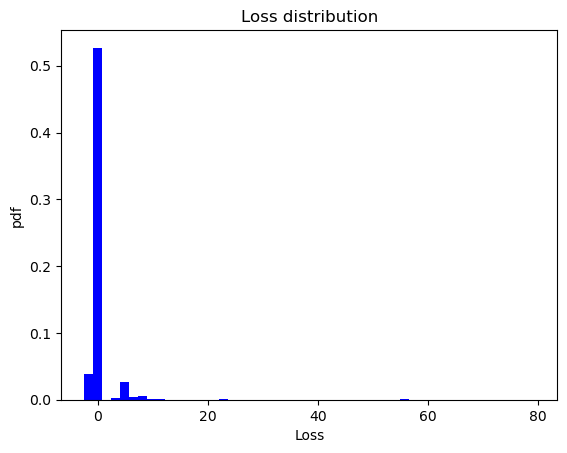

In [95]:
num_bins = 50

# Create the histogram
plt.hist(MC_losses, bins=num_bins, color='blue', density = True)


# Add labels and title
plt.xlabel('Loss')
plt.ylabel('pdf')
plt.title('Loss distribution')

# Display the plot
plt.show()

In [96]:
#7 BHS
sorted_MC_losses = sorted(MC_losses, key=lambda x: x, reverse=True)

alpha = [0.99, 0.999, 0.9999]

N = 100000

VaR_sim = []

for i in range(len(alpha)):
    idx = int((1-alpha[i])*N + 1)
    VaR_sim.append(sorted_MC_losses[idx-1])

print(VaR_sim)
print(VaR)

[8.870000000000001, 55.84, 64.95]
[8.540000000000001, 55.51, 55.730000000000004]


VaR_sim with R = 0.35: [8.87, 55.84, 64.95]

VaR_sim with R = 0: [8.87, 55.84, 57.04]

VaR_predicted = [8.54, 55.51, 55.73]

8a: If you look at the loss distribution: For low VaR levels it is somewhat similar to a normal distribution, but the problem is that the loss distribution has a very long tail so for more extreme VaR there is a large difference.

8b: It doesn't matter that much for low VaR levels but for high VaR levels (high alpha) it matters a lot. Think about this way: The most extreme values p1 and p2 have a low probability. If two assets are uncorrelated (rho = 0) the probability p1 * p2 will also be very low. However if the assets have a perfect correlation (rho=1) then extreme events will always occur together and so the probability for very high losses will also increase. 
